In [ ]:
# This cell may only need to be run once... Not sure yet

! rm -r temp
! mkdir temp
! git clone https://github.com/cyang-kth/fmm.git ./temp

import os
# change working directory
os.chdir("temp")

if not os.path.exists('build'):
  os.mkdir('build')
# ! mkdir build
os.chdir("build")
# ! cd build
! cmake ..
! make -j4
! sudo make install

# A quick test

# Change to the parent folder which contains fmm_test.py
# cd ../example/python
if os.getcwd() != "/content/fmm/example/python":
  os.chdir("/content/fmm/example/python")
os.system('python fmm_test.py')

! rm -r ./temp


Cloning into './temp'...
'cmake' is not recognized as an internal or external command,
operable program or batch file.
'make' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/fmm/example/python'

In [ ]:
# Run this cell to see if fmm is installed properly

! fmm

## A New Approach to Map Matching Algorithms

### A project sponsered by Mitsubishi in Sendai, Japan

Team: Seiya Omura, Tomoya Akamatsu, Katelynn Huneycutt, Gabriel Gress


In [ ]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np

%matplotlib inline
ox.__version__

'1.2.1'

First, we download from OSM a street map for a section of Sendai, JP-- particularly, the area around Tohoku University. However, OSMnx by default does not track directionality of roads-- this is an important factor when map matching, so we use a script created by cyang-kth for their fmm program which saves this information.

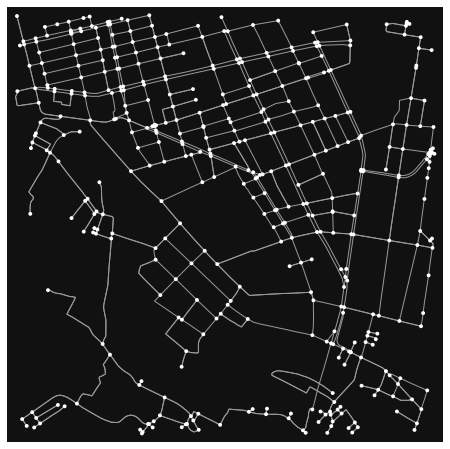

C:\Users\GRIPS\AppData\Local\Temp\ipykernel_14860\2730063922.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


In [ ]:
def save_graph_shapefile_directional(G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    # We need an unique ID for each edge
    gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')
    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)


M = ox.graph_from_address("Katahira Campus, 1, Kitamemachi-dori, Katahira 2-chome, Kitamemachi, Aoba Ward, Sendai, Miyagi Prefecture, 980-8577, Japan", network_type='drive')
fig, ax = ox.plot_graph(M)

save_graph_shapefile_directional(M, filepath='Tohoku')

The default format that OSMnx models networks is as `MultiDiGraph` objects. In order to manipulate these objects mathematically, we will need to convert this to `GeoDataFrame`. 

In [ ]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(S)
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
244318293,38.302387,140.886141,3,NaN,NaN,POINT (140.88614 38.30239)
244318294,38.302262,140.886609,3,NaN,NaN,POINT (140.88661 38.30226)
244318306,38.301317,140.888557,4,traffic_signals,NaN,POINT (140.88856 38.30132)
244318307,38.300941,140.888603,4,NaN,NaN,POINT (140.88860 38.30094)
244318311,38.301027,140.889769,3,NaN,NaN,POINT (140.88977 38.30103)


In [ ]:
gdf_edges.head()

osmid       highway  oneway reversed   length  \
u         v          key                                                     
244318293 1207157788 0    61724603  unclassified   False    False   81.898   
          1207235075 0    22762217  unclassified   False     True  139.726   
          244318294  0    22762218   residential   False    False   43.334   
244318294 3733247561 0    22762219   residential   False    False   38.649   
          244318293  0    22762218   residential   False     True   43.334   

                                                                   geometry  \
u         v          key                                                      
244318293 1207157788 0    LINESTRING (140.88614 38.30239, 140.88575 38.3...   
          1207235075 0    LINESTRING (140.88614 38.30239, 140.88627 38.3...   
          244318294  0    LINESTRING (140.88614 38.30239, 140.88638 38.3...   
244318294 3733247561 0    LINESTRING (140.88661 38.30226, 140.88664 38.3...   
          244318293  0    LINESTRING (140.88661 38.30226, 140.88653 38.3...   

                         lanes name  ref maxspeed bridge access tunnel  \
u         v          key                                                 
244318293 1207157788 0     NaN  NaN  NaN      NaN    NaN    NaN    NaN   
          1207235075 0     NaN  NaN  NaN      NaN    NaN    NaN    NaN   
          244318294  0     NaN  NaN  NaN      NaN    NaN    NaN    NaN   
244318294 3733247561 0     NaN  NaN  NaN      NaN    NaN    NaN    NaN   
          244318293  0     NaN  NaN  NaN      NaN    NaN    NaN    NaN   

                         junction  
u         v          key           
244318293 1207157788 0        NaN  
          1207235075 0        NaN  
          244318294  0        NaN  
244318294 3733247561 0        NaN  
          244318293  0        NaN

Now let's look at the GPS data from a day walking around Sendai.

In [ ]:
import geopandas as gpd
# Enable KML driver
gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"

# Read file from KML
fp = "history-2022-06-20.kml"
tripdata = gpd.read_file(fp, driver='KML')

<AxesSubplot:>

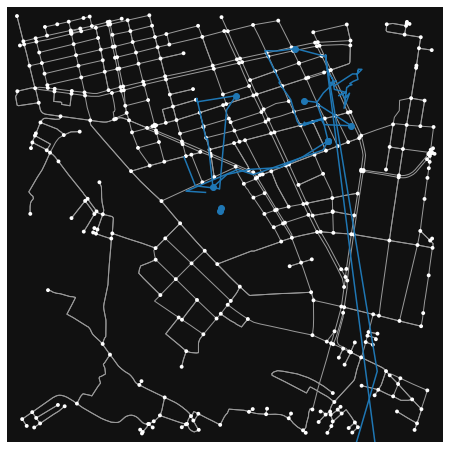

In [ ]:
fig, ax = ox.plot_graph(M,show=False, close=False)
tripdata.plot(ax=ax)

Now we will run this information through FMM as a baseline. To do this we will first need to convert our GeoDataFrame to a Shapefile.

In [ ]:
# Simplify tripdata to only LineStrings
td = tripdata[tripdata.geom_type == 'LineString'].geometry

# Write to Shapefile (just make a copy)
outfp = "temp/history-2022-06-20.shp"
td.to_file(outfp)

Because FMM uses the same network datatype as us, we do not need to make any modifications to our network. Now we are ready to use FMM.